In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 4
n_values = [25, 50, 100, 250, 500]
b = np.ones(m)

In [10]:
# Number of times to solve the dual equation.
num_dual_samples = 1000

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

# Solve for the stochastic program

In [5]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    A = np.random.uniform(-0.5, 1, (m, num_stoc_samples))
    pi = np.random.uniform(0, 10, num_stoc_samples)
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



With n=25, iteration completed in 7.88 s
[5.61464231 5.55866378 5.65750216 5.59907295]

With n=50, iteration completed in 10.75 s
[7.11636956 7.146839   7.15639555 7.02369484]

With n=100, iteration completed in 17.77 s
[8.5344044  8.40814808 8.41289631 8.36962206]

With n=250, iteration completed in 24.65 s
[9.4364108  9.44627481 9.53572743 9.62103348]

With n=500, iteration completed in 31.60 s
[10.2421843  10.08808889 10.17312816 10.21785084]


# Solve for the dual problem for various values of n

In [11]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.random.uniform(0, 10, n)

        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 25
Average of all dual solutions: [5.6226403  5.6598919  5.65531011 5.59885156]
Expectation of L2 norm between p*n and p* is: 56.67
m log m log log n / n for m=4 and n=25 is: 0.26
Constant C is: 218.548

For n = 50
Average of all dual solutions: [7.3147557  7.38637261 7.26053358 7.41865572]
Expectation of L2 norm between p*n and p* is: 46.14
m log m log log n / n for m=4 and n=50 is: 0.15
Constant C is: 304.995

For n = 100
Average of all dual solutions: [8.65828336 8.62157371 8.48440727 8.74148176]
Expectation of L2 norm between p*n and p* is: 28.66
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 338.478

For n = 250
Average of all dual solutions: [9.83865902 9.72152871 9.66496214 9.80758547]
Expectation of L2 norm between p*n and p* is: 15.04
m log m log log n / n for m=4 and n=250 is: 0.04
Constant C is: 396.820

For n = 500
Average of all dual solutions: [10.29930294 10.34707882 10.31321738 10.29280534]
Expectation of L2 norm between p*n and p* is: 8.60
m lo

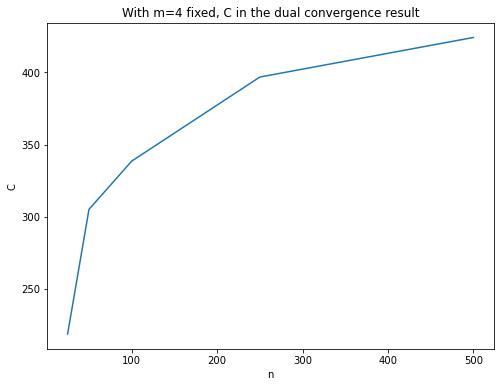

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

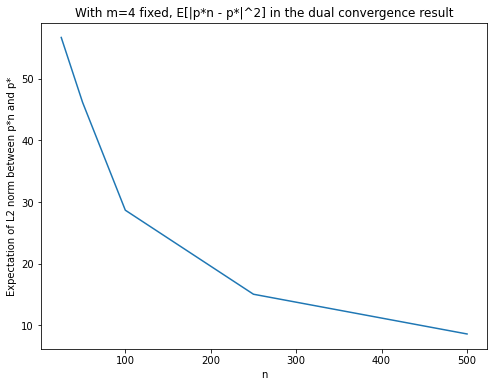

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()